# Baseline Model Comparison

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, precision_score, recall_score, f1_score, fbeta_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from imblearn.over_sampling import SMOTE  
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel
import numpy as np


## 1. Load Data and Check Data Quality

In [4]:
# === Load Data ===
df = pd.read_parquet("data/processed/creditcard_processed.parquet", engine='pyarrow')
X = df.drop(columns=["Class"])
y = df["Class"]

# === Dimension of the Data ===
rows, cols = df.shape
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')

# === Check Data Quality ===
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If you want to see how many rows have missing data
rows_missing_data = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing data: {len(rows_missing_data)}")

Number of rows: 284807
Number of columns: 35
Number of duplicate rows: 1081
Number of rows with missing data: 0


## 2. Observe Data Characteristic

In [5]:
# Basic statistics
print(f"\n=== CLASS DISTRIBUTION ===")
class_dist = df['Class'].value_counts()
print(f"Non-Fraud (0): {class_dist[0]:,} ({class_dist[0]/len(df)*100:.2f}%)")
print(f"Fraud (1): {class_dist[1]:,} ({class_dist[1]/len(df)*100:.2f}%)")


=== CLASS DISTRIBUTION ===
Non-Fraud (0): 284,315 (99.83%)
Fraud (1): 492 (0.17%)


We can observe that the data is very imbalnced where only 0.17% of the data are fraudulent transactions

## 3. Data Pre-processing

In [6]:
# === Remove Duplicated Data ===
df_clean = df.drop_duplicates()


# === Dimension of the Data ===
rows, cols = df_clean.shape
print(f'Number of rows: {rows}')
print(f'Number of columns: {cols}')

# === Check Data Quality ===
duplicates = df_clean.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# If you want to see how many rows have missing data
rows_missing_data = df_clean[df_clean.isnull().any(axis=1)]
print(f"Number of rows with missing data: {len(rows_missing_data)}")

df = df_clean # for simplicity


Number of rows: 283726
Number of columns: 35
Number of duplicate rows: 0
Number of rows with missing data: 0


## 4. Prepping Data

c:\Users\GaryG\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\GaryG\AppData\Local\Temp\ipykernel_40660\2688581984.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars_before = sns.barplot(x=before_counts.index, y=before_counts.values, palette="coolwarm", ax=axes[0])
C:\Users\GaryG\AppData\Local\Temp\ipykernel_40660\2688581984.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars_after = sns.barplot(x=after_counts.index, y=after_counts.values, palette="cool

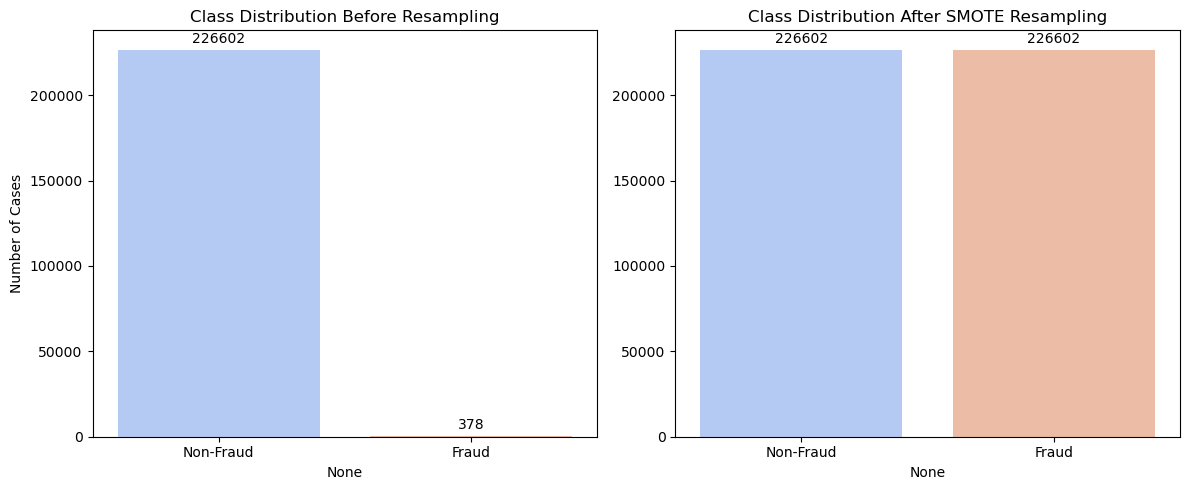

In [7]:
X = df.drop(columns=["Class"])
y = df["Class"]

# === Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=156
)

# === Feature Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === Resampling (Optional: SMOTE) ===
smote = SMOTE(sampling_strategy='auto', random_state=156)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# === Plot Class Distribution Before and After SMOTE ===
before_counts = pd.Series(
    [(y_train == 0).sum(), (y_train == 1).sum()],
    index=['Non-Fraud', 'Fraud']
)
after_counts = pd.Series(
    [(y_train_resampled == 0).sum(), (y_train_resampled == 1).sum()],
    index=['Non-Fraud', 'Fraud']
)


fig, axes = plt.subplots(1, 2, figsize=(12, 5))

bars_before = sns.barplot(x=before_counts.index, y=before_counts.values, palette="coolwarm", ax=axes[0])
axes[0].set_title("Class Distribution Before Resampling")
axes[0].set_ylabel("Number of Cases")
for p in bars_before.patches:
    axes[0].annotate(format(int(p.get_height()), 'd'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 8), textcoords='offset points')

bars_after = sns.barplot(x=after_counts.index, y=after_counts.values, palette="coolwarm", ax=axes[1])
axes[1].set_title("Class Distribution After SMOTE Resampling")
for p in bars_after.patches:
    axes[1].annotate(format(int(p.get_height()), 'd'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 8), textcoords='offset points')

plt.tight_layout()
plt.show()



## 5. Logistic Regression

In [14]:
log_reg = LogisticRegression(class_weight='balanced',)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on test set
log_reg_preds = log_reg.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
print('Accuracy:', metrics.accuracy_score(y_test,log_reg_preds),'\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,log_reg_preds))
report_dict = classification_report(y_test, log_reg_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)

Accuracy: 0.9729496352165792 

Confusion Matrix:
[[55124  1527]
 [    8    87]]
              precision    recall  f1-score      support
0              0.999855  0.973045  0.986268  56651.00000
1              0.053903  0.915789  0.101814     95.00000
accuracy       0.972950  0.972950  0.972950      0.97295
macro avg      0.526879  0.944417  0.544041  56746.00000
weighted avg   0.998271  0.972950  0.984787  56746.00000


## 6. kNN - k Nearest Neighbours

In [57]:
kNN = KNeighborsClassifier()
kNN.fit(X_train_resampled, y_train_resampled)

# Predict on test set
kNN_preds = kNN.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
print('Accuracy:', metrics.accuracy_score(y_test,kNN_preds),'\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,kNN_preds))
report_dict = classification_report(y_test, kNN_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)

Accuracy: 0.9983258731892997 

Confusion Matrix:
[[56574    77]
 [   18    77]]
              precision    recall  f1-score       support
0              0.999682  0.998641  0.999161  56651.000000
1              0.500000  0.810526  0.618474     95.000000
accuracy       0.998326  0.998326  0.998326      0.998326
macro avg      0.749841  0.904584  0.808817  56746.000000
weighted avg   0.998845  0.998326  0.998524  56746.000000


## 7. Random Forest

Accuracy: 0.9995241955380115 

Confusion Matrix:
[[56644     7]
 [   20    75]]
              precision    recall  f1-score       support
0              0.999647  0.999876  0.999762  56651.000000
1              0.914634  0.789474  0.847458     95.000000
accuracy       0.999524  0.999524  0.999524      0.999524
macro avg      0.957141  0.894675  0.923610  56746.000000
weighted avg   0.999505  0.999524  0.999507  56746.000000


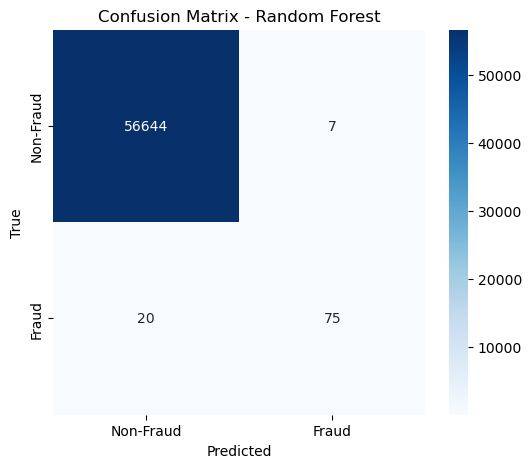

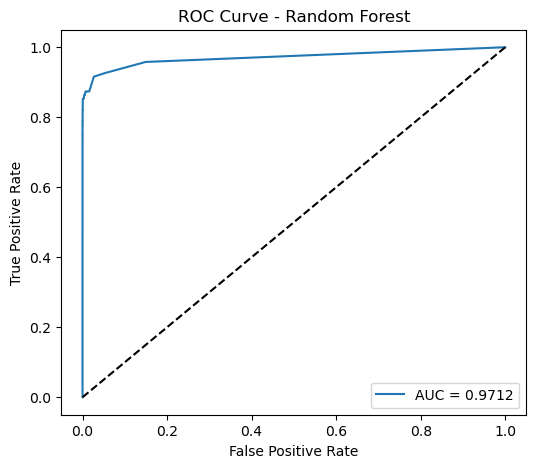

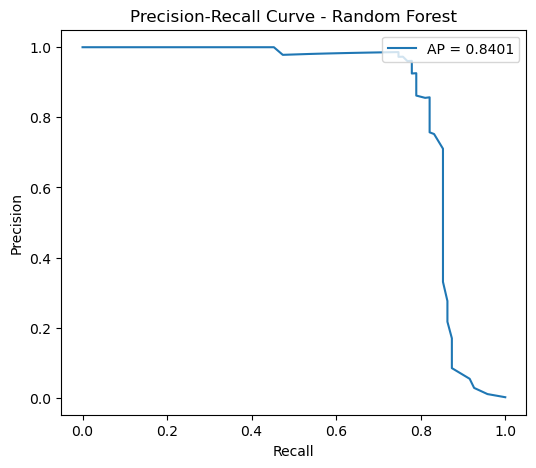

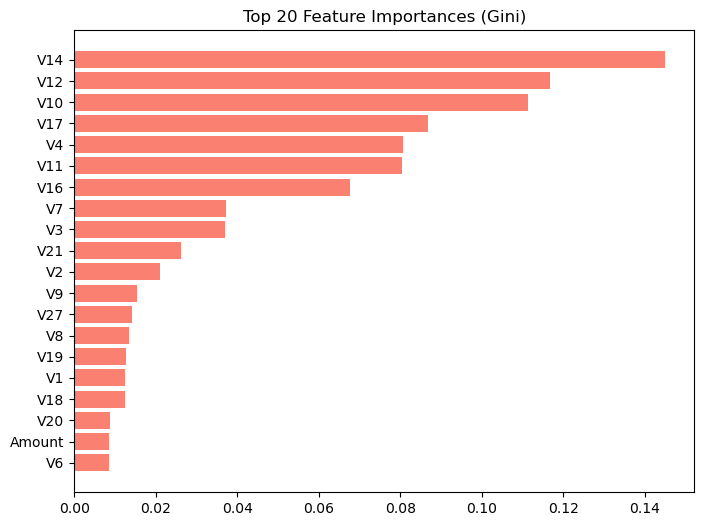

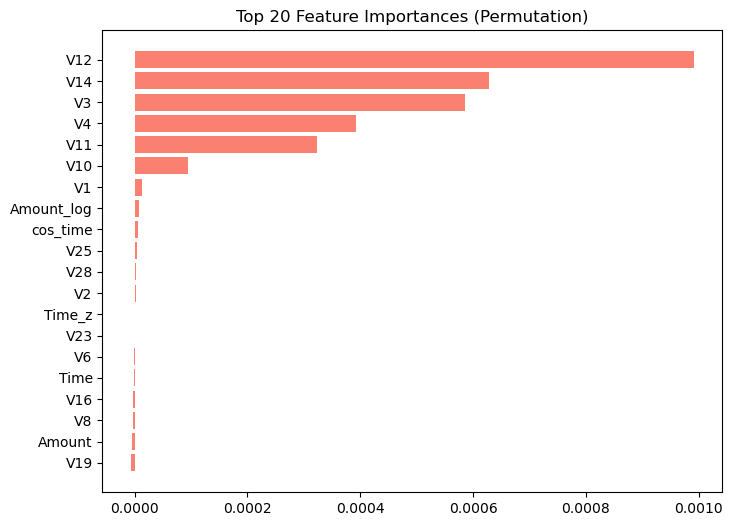

In [27]:
# === Original Random Forest ===
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

# === Predictions ===
rf_preds = rf.predict(X_test_scaled)
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]  # Needed for ROC and PR curves

# === Metrics ===
print('Accuracy:', metrics.accuracy_score(y_test, rf_preds), '\n')
print('Confusion Matrix:')
cm = metrics.confusion_matrix(y_test, rf_preds)
print(cm)
report_dict = classification_report(y_test, rf_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print(report_df)

# === Confusion Matrix Heatmap ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, rf_proba)
avg_precision = average_precision_score(y_test, rf_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc='upper right')
plt.show()

# === Feature Importance (Gini) ===
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(20), importances[indices[:20]], align='center', color='salmon')
plt.yticks(range(20), X.columns[indices[:20]])
plt.title("Top 20 Feature Importances (Gini)")
plt.gca().invert_yaxis()
plt.show()

# === Permutation Importance ===
perm_importance = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(20), perm_importance.importances_mean[perm_sorted_idx][-20:], color='salmon')
plt.yticks(range(20), X.columns[perm_sorted_idx][-20:])
plt.title("Top 20 Feature Importances (Permutation)")
plt.show()


## 8. SVM

### 8.1 Linear SVM

In [59]:
linear_svm = LinearSVC()

linear_svm.fit(X_train_resampled, y_train_resampled)

# Predict on test set
linear_svm_preds = linear_svm.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
print('Accuracy:', metrics.accuracy_score(y_test,linear_svm_preds),'\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,linear_svm_preds))
report_dict = classification_report(y_test, linear_svm_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)


Accuracy: 0.9789588693476192 

Confusion Matrix:
[[55467  1184]
 [   10    85]]
              precision    recall  f1-score       support
0              0.999820  0.979100  0.989351  56651.000000
1              0.066982  0.894737  0.124633     95.000000
accuracy       0.978959  0.978959  0.978959      0.978959
macro avg      0.533401  0.936918  0.556992  56746.000000
weighted avg   0.998258  0.978959  0.987904  56746.000000


### 8.2 Polynomial SVM (Degree = 2)

In [60]:
poly_svm = SVC(kernel='poly', degree=2, class_weight='balanced', random_state=156)


poly_svm.fit(X_train_resampled, y_train_resampled)

# Predict on test set
poly_svm_preds = poly_svm.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
print('Accuracy:', metrics.accuracy_score(y_test,poly_svm_preds),'\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,poly_svm_preds))
report_dict = classification_report(y_test, poly_svm_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)


Accuracy: 0.9902195749480139 

Confusion Matrix:
[[56112   539]
 [   16    79]]
              precision    recall  f1-score      support
0              0.999715  0.990486  0.995079  56651.00000
1              0.127832  0.831579  0.221599     95.00000
accuracy       0.990220  0.990220  0.990220      0.99022
macro avg      0.563773  0.911032  0.608339  56746.00000
weighted avg   0.998255  0.990220  0.993784  56746.00000


### 8.3 RBF 

In [61]:
rbf_svm = SVC(kernel='poly', degree=2, class_weight='balanced', random_state=156)


rbf_svm.fit(X_train_resampled, y_train_resampled)

# Predict on test set
rbf_svm_preds = poly_svm.predict(X_test_scaled)

# Calculate accuracy and confusion matrix
print('Accuracy:', metrics.accuracy_score(y_test,rbf_svm_preds),'\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_test,rbf_svm_preds))
report_dict = classification_report(y_test, rbf_svm_preds, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

print(report_df)


Accuracy: 0.9902195749480139 

Confusion Matrix:
[[56112   539]
 [   16    79]]
              precision    recall  f1-score      support
0              0.999715  0.990486  0.995079  56651.00000
1              0.127832  0.831579  0.221599     95.00000
accuracy       0.990220  0.990220  0.990220      0.99022
macro avg      0.563773  0.911032  0.608339  56746.00000
weighted avg   0.998255  0.990220  0.993784  56746.00000


## 9. Random Forest Hyperparameter Tuning

The baseline Random Forest model already performs well, but we can potentially improve its performance by tuning key hyperparameters. Random Forest models have several parameters such as the number of trees (`n_estimators`), maximum depth of trees (`max_depth`), and the number of features considered at each split (`max_features`). 

Given that our dataset is highly imbalanced, we will use **F1-score** as the optimization metric instead of accuracy to better balance precision and recall. 

We will apply **RandomizedSearchCV** with **5-fold Stratified Cross-Validation** to efficiently search through a range of hyperparameters, rather than exhaustively testing every combination. This approach helps us find a good trade-off between performance and training time.


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=171; total time= 6.6min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=171; total time= 6.8min
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=171; total time= 6.9min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=251; total time= 8.7min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=251; total time= 9.3min
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=251; total time= 9.6min
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=314; total 

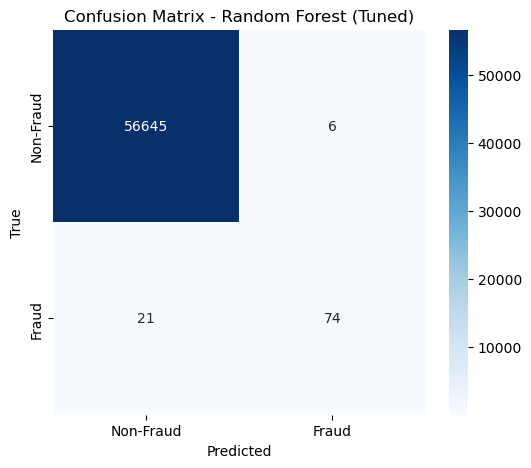

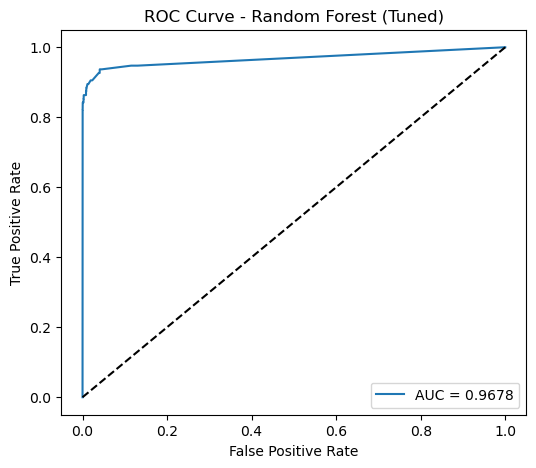

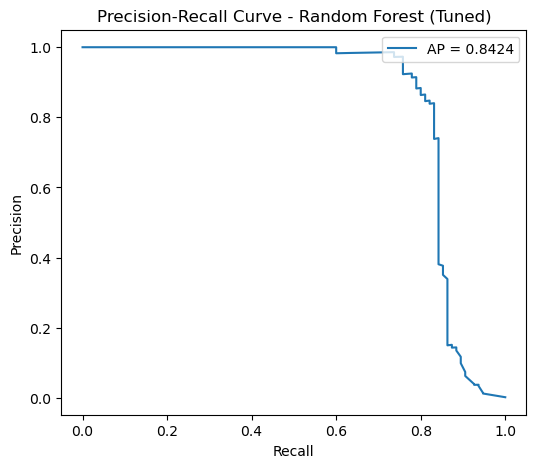

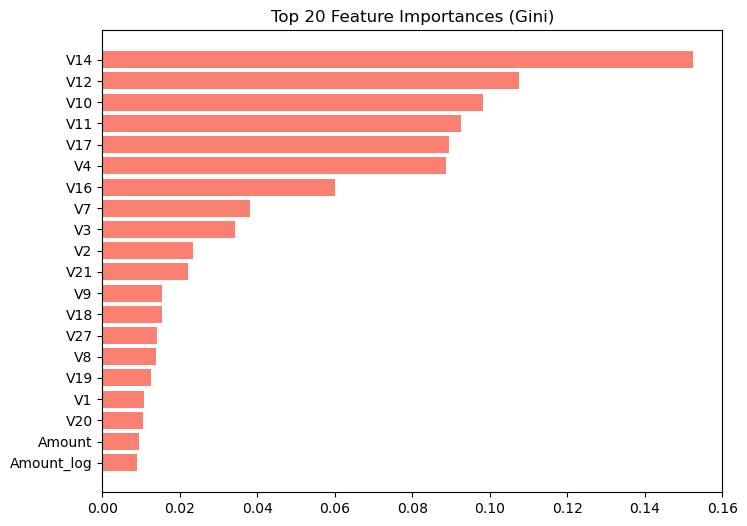

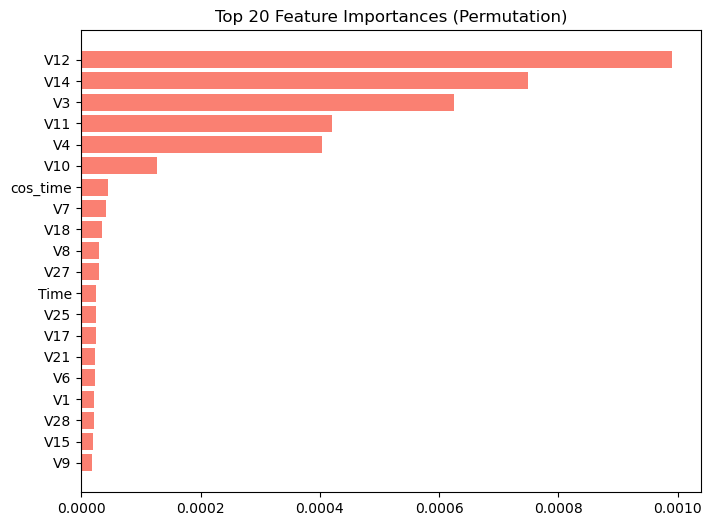

In [ ]:
# === Hyperparameter Grid for Random Forest ===
param_dist = {
    'n_estimators': randint(100, 400),  # Reduced range
    'max_depth': [None, 10, 20, 30, 40],  # Fewer depth options
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# === Initialize Random Forest Model ===
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# === Cross-Validation Strategy (3-Fold) ===
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# === Randomized Search (10 Candidates) ===
rf_random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    n_jobs=-1,
    cv=cv_strategy,
    verbose=2,
    random_state=42
)

# === Fit Random Search on Resampled Training Data ===
rf_random_search.fit(X_train_resampled, y_train_resampled)

# === Best Model from Search ===
best_rf = rf_random_search.best_estimator_
print("Best Random Forest Parameters:", rf_random_search.best_params_)

# === Predictions ===
rf_preds = best_rf.predict(X_test_scaled)
rf_proba = best_rf.predict_proba(X_test_scaled)[:, 1]

# === Metrics ===
print('Accuracy:', metrics.accuracy_score(y_test, rf_preds))
print('Confusion Matrix:\n', confusion_matrix(y_test, rf_preds))
print(pd.DataFrame(classification_report(y_test, rf_preds, output_dict=True)).transpose())

# === Confusion Matrix Heatmap ===
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - Random Forest (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Tuned)')
plt.legend(loc='lower right')
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, rf_proba)
avg_precision = average_precision_score(y_test, rf_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest (Tuned)')
plt.legend(loc='upper right')
plt.show()

# === Feature Importance (Gini) ===
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(20), importances[indices[:20]], align='center', color='salmon')
plt.yticks(range(20), X.columns[indices[:20]])
plt.title("Top 20 Feature Importances (Gini)")
plt.gca().invert_yaxis()
plt.show()

# === Permutation Importance ===
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(20), perm_importance.importances_mean[perm_sorted_idx][-20:], color='salmon')
plt.yticks(range(20), X.columns[perm_sorted_idx][-20:])
plt.title("Top 20 Feature Importances (Permutation)")
plt.show()


### 10. F1-Score Threshold Optimization

While tuning the Random Forest hyperparameters improves the model’s overall performance, the **classification threshold (default 0.5)** can still lead to suboptimal results, especially on **highly imbalanced datasets**. In our case, missing fraudulent transactions (false negatives) is far more costly than flagging a few extra legitimate transactions (false positives).

To address this, we perform **F1-score threshold optimization**:
- We evaluate multiple thresholds between 0 and 1.
- For each threshold, we calculate **precision, recall, and F1-score**.
- We select the threshold that **maximizes the F1-score**, ensuring a balanced trade-off between **catching fraud (recall)** and **avoiding false alarms (precision)**.

This approach allows us to **reduce false negatives (e.g., 21 missed fraud cases)** while maintaining strong precision, improving the model’s real-world effectiveness.


Accuracy (0.5 threshold): 0.9995241955380115
Confusion Matrix (0.5 threshold):
[[56644     7]
 [   20    75]]
              precision    recall  f1-score       support
0              0.999647  0.999876  0.999762  56651.000000
1              0.914634  0.789474  0.847458     95.000000
accuracy       0.999524  0.999524  0.999524      0.999524
macro avg      0.957141  0.894675  0.923610  56746.000000
weighted avg   0.999505  0.999524  0.999507  56746.000000

Best F1 Threshold: 0.57 (F1 = 0.8605)


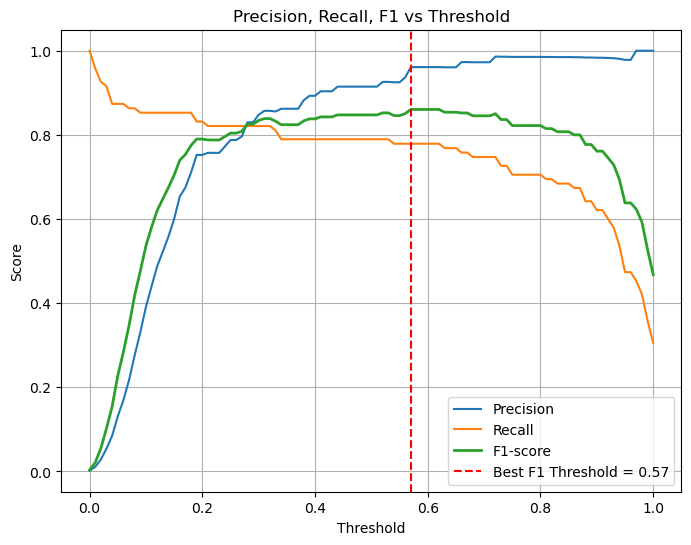


Confusion Matrix at Optimal F1 Threshold:
[[56648     3]
 [   21    74]]
              precision    recall  f1-score       support
0              0.999629  0.999947  0.999788  56651.000000
1              0.961039  0.778947  0.860465     95.000000
accuracy       0.999577  0.999577  0.999577      0.999577
macro avg      0.980334  0.889447  0.930127  56746.000000
weighted avg   0.999565  0.999577  0.999555  56746.000000


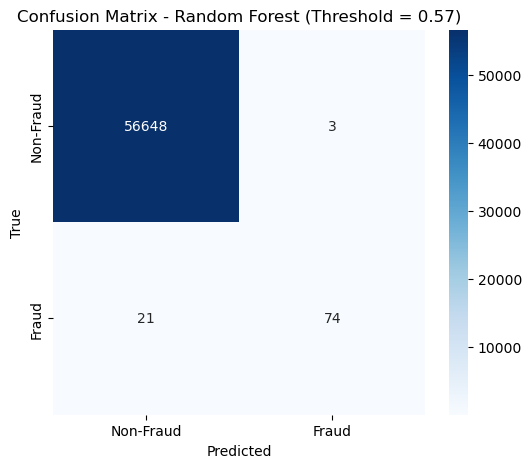

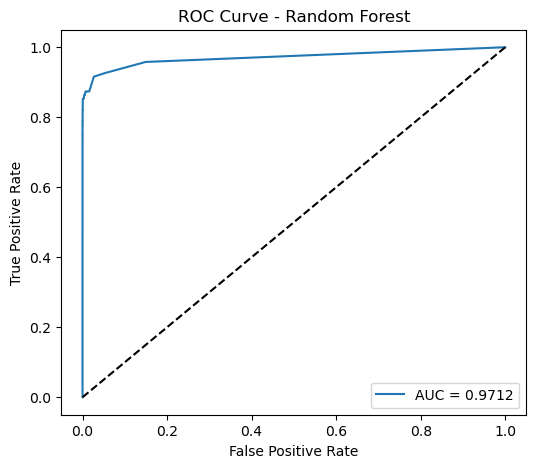

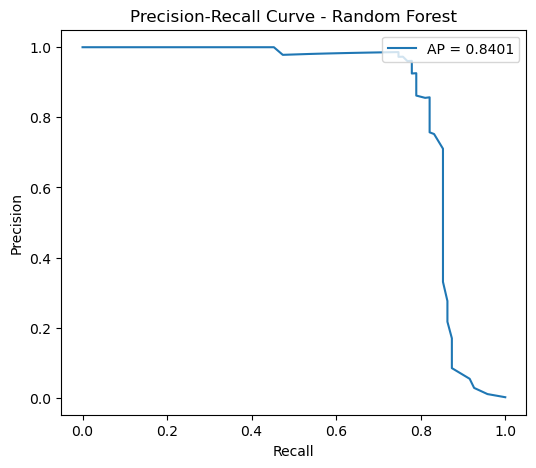

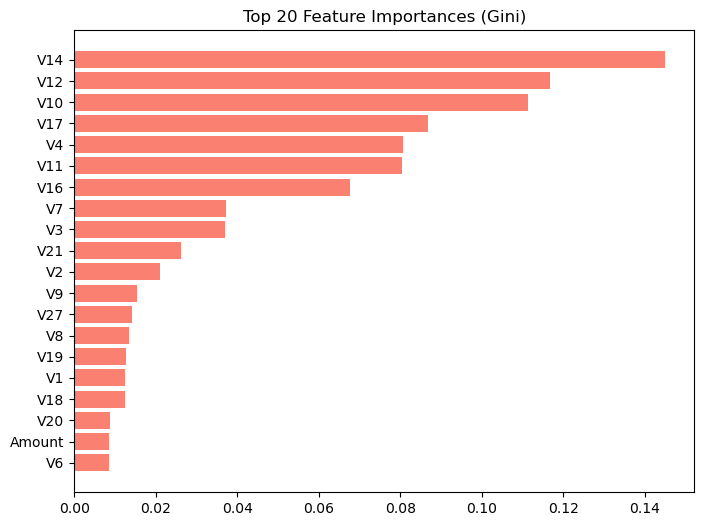

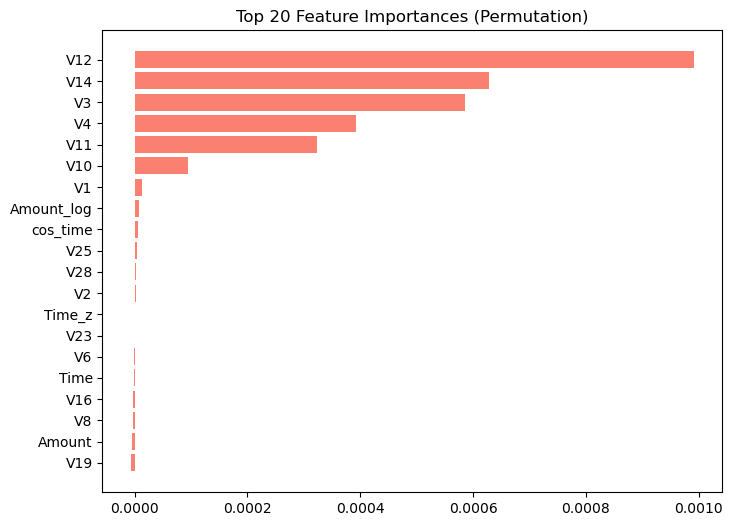

In [36]:
# === Train Original Random Forest ===
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)

# === Predict Probabilities and Labels (default 0.5 threshold) ===
rf_proba = rf.predict_proba(X_test_scaled)[:, 1]
rf_preds = (rf_proba >= 0.5).astype(int)

# === Metrics (Default Threshold) ===
print('Accuracy (0.5 threshold):', metrics.accuracy_score(y_test, rf_preds))
print('Confusion Matrix (0.5 threshold):')
print(confusion_matrix(y_test, rf_preds))
print(pd.DataFrame(classification_report(y_test, rf_preds, output_dict=True)).transpose())

# === F1-Optimal Threshold Tuning ===
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores, recall_scores, f1_scores = [], [], []

for t in thresholds:
    preds = (rf_proba >= t).astype(int)
    precision_scores.append(precision_score(y_test, preds))
    recall_scores.append(recall_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest F1 Threshold: {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.4f})")

# === Plot Precision, Recall, F1 vs Threshold ===
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best F1 Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold')
plt.legend()
plt.grid()
plt.show()

# === Predictions at Optimal F1 Threshold ===
rf_preds_opt = (rf_proba >= best_threshold).astype(int)
print("\nConfusion Matrix at Optimal F1 Threshold:")
cm_opt = confusion_matrix(y_test, rf_preds_opt)
print(cm_opt)
print(pd.DataFrame(classification_report(y_test, rf_preds_opt, output_dict=True)).transpose())

# === Confusion Matrix Heatmap (Optimal Threshold) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - Random Forest (Threshold = {best_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, rf_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, rf_proba)
avg_precision = average_precision_score(y_test, rf_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Random Forest')
plt.legend(loc='upper right')
plt.show()

# === Feature Importance (Gini) ===
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 6))
plt.barh(range(20), importances[indices[:20]], align='center', color='salmon')
plt.yticks(range(20), X.columns[indices[:20]])
plt.title("Top 20 Feature Importances (Gini)")
plt.gca().invert_yaxis()
plt.show()

# === Permutation Importance ===
perm_importance = permutation_importance(rf, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(range(20), perm_importance.importances_mean[perm_sorted_idx][-20:], color='salmon')
plt.yticks(range(20), X.columns[perm_sorted_idx][-20:])
plt.title("Top 20 Feature Importances (Permutation)")
plt.show()


# 11. KNN Hyperparameter Tuning

## 11.1 Feature Selection

In [8]:
# === Feature Selection using SelectFromModel (Random Forest) ===
rf_selector = RandomForestClassifier(n_estimators=100, random_state=156)
sfm = SelectFromModel(estimator=rf_selector, threshold="median")  # or use threshold=0.01
sfm.fit(X_train_scaled, y_train)

# Get selected feature names
selected_features = X.columns[sfm.get_support()].tolist()

# Sort selected features by importance
importances = sfm.estimator_.feature_importances_[sfm.get_support()]
sorted_idx = np.argsort(importances)[::-1]  # descending order

print("Selected Features After SelectFromModel (Sorted by Importance):")
for i in sorted_idx:
    print(f"{i+1}. {selected_features[i]} (Importance: {importances[i]:.6f})")

Selected Features After SelectFromModel (Sorted by Importance):
11. V17 (Importance: 0.138593)
8. V12 (Importance: 0.132561)
9. V14 (Importance: 0.106943)
6. V10 (Importance: 0.089253)
7. V11 (Importance: 0.068809)
10. V16 (Importance: 0.063857)
5. V9 (Importance: 0.035351)
12. V18 (Importance: 0.033748)
4. V7 (Importance: 0.031591)
3. V6 (Importance: 0.020828)
2. V4 (Importance: 0.020588)
16. V26 (Importance: 0.017813)
15. V21 (Importance: 0.017056)
17. sin_time (Importance: 0.016100)
13. V19 (Importance: 0.013525)
1. V3 (Importance: 0.013156)
14. V20 (Importance: 0.012573)


## 11.2 Prepping Data, Resampling

In [12]:
# === Re-define Train/Test using Selected Features Only ===
X_train_selected = sfm.transform(X_train_scaled)
X_test_selected = sfm.transform(X_test_scaled)

# === Resampling (Optional: SMOTE) ===
smote = SMOTE(random_state=156)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
unique, counts = np.unique(y_train_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class distribution in y_train_resampled (after SMOTE):")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")

Class distribution in y_train_resampled (after SMOTE):
Class 0: 226602 samples
Class 1: 226602 samples


c:\Users\GaryG\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


## 11.3 Grid Search For KNN With Best F1 Score

In [14]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, scoring="f1", cv=3, verbose=3, n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
best_knn = grid_search.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


Accuracy: 0.9983611179642617
Confusion Matrix:
 [[56576    75]
 [   18    77]]
              precision    recall  f1-score       support
0              0.999682  0.998676  0.999179  56651.000000
1              0.506579  0.810526  0.623482     95.000000
accuracy       0.998361  0.998361  0.998361      0.998361
macro avg      0.753130  0.904601  0.811330  56746.000000
weighted avg   0.998856  0.998361  0.998550  56746.000000


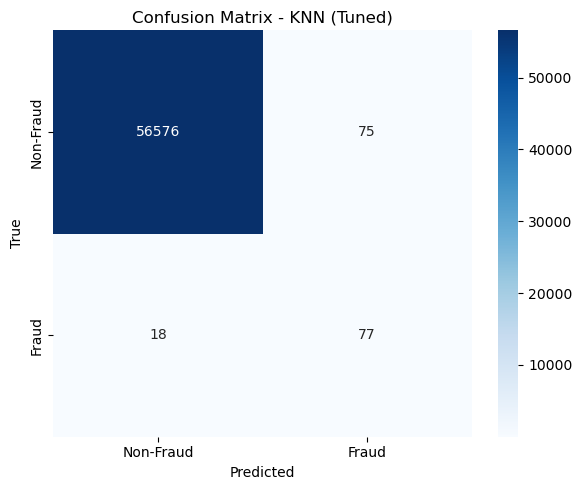


ROC AUC Score: 0.9048


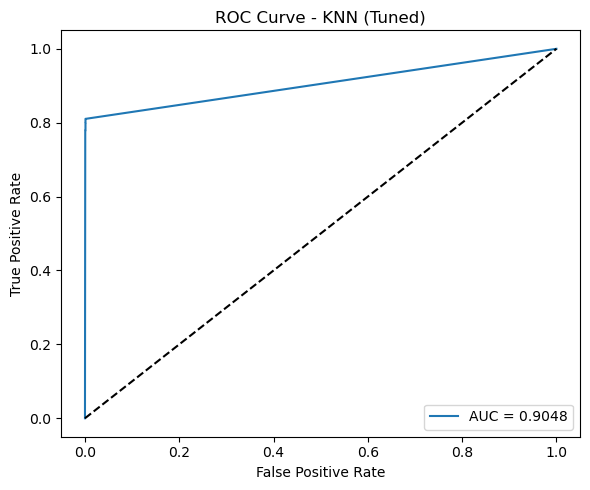

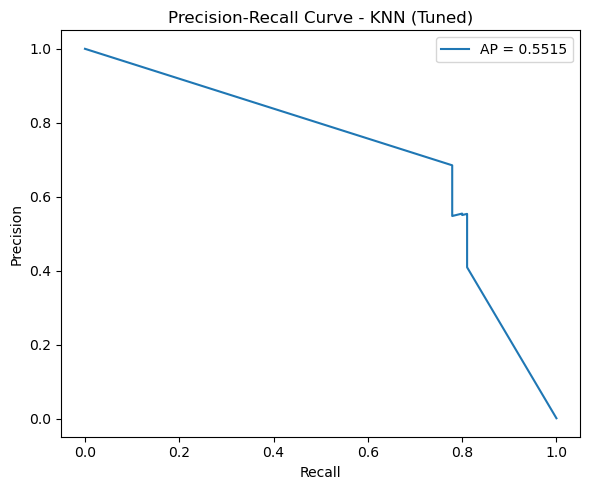

In [20]:
# === Evaluate Model on Test Set ===
y_pred = best_knn.predict(X_test_selected)
y_proba = best_knn.predict_proba(X_test_selected)[:, 1]

# === Metrics ===
print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose())

# === Confusion Matrix Heatmap ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix - KNN (Tuned)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("knn_confusion_matrix_tuned.png", dpi=300)
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (Tuned)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("knn_roc_curve_tuned.png", dpi=300)
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN (Tuned)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("knn_precision_recall_curve_tuned.png", dpi=300)
plt.show()

## 11.4 F1 Score Threshold Optimization

In [18]:
thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores, recall_scores, f1_scores = [], [], []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    precision_scores.append(precision_score(y_test, preds, zero_division=0))
    recall_scores.append(recall_score(y_test, preds))
    f1_scores.append(f1_score(y_test, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"\nBest F1 Threshold: {best_threshold:.2f} (F1 = {f1_scores[best_idx]:.4f})")


Best F1 Threshold: 0.67 (F1 = 0.7291)


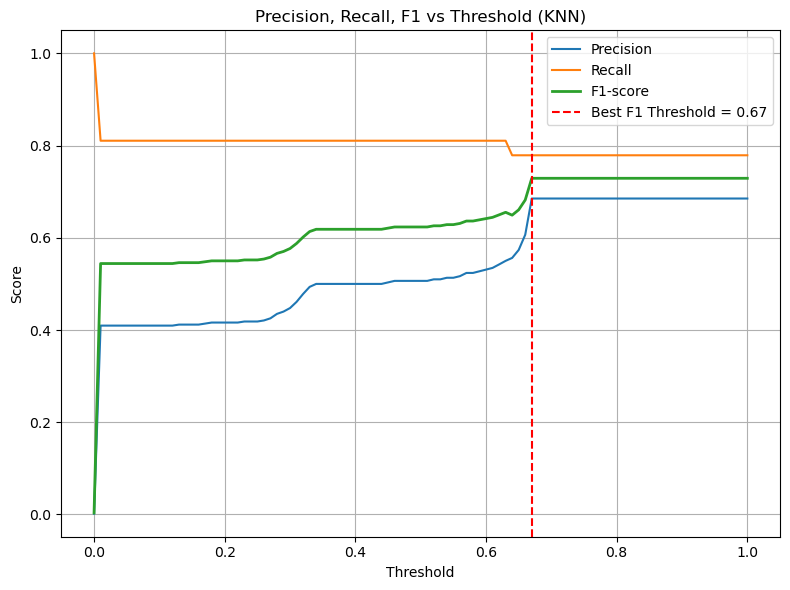


Confusion Matrix at Best F1 Threshold:
[[56617    34]
 [   21    74]]
              precision    recall  f1-score       support
0              0.999629  0.999400  0.999515  56651.000000
1              0.685185  0.778947  0.729064     95.000000
accuracy       0.999031  0.999031  0.999031      0.999031
macro avg      0.842407  0.889174  0.864289  56746.000000
weighted avg   0.999103  0.999031  0.999062  56746.000000


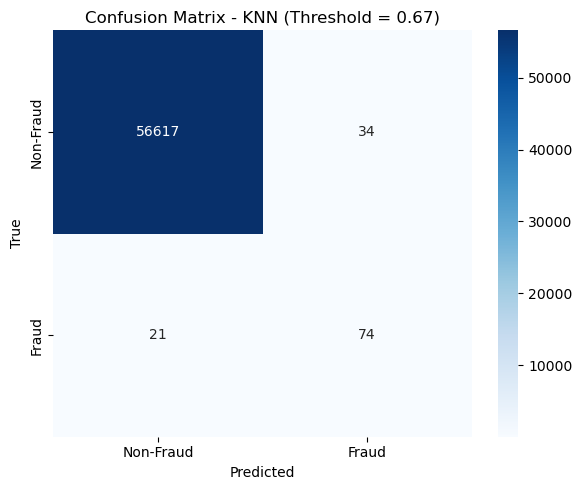


ROC AUC Score: 0.9048


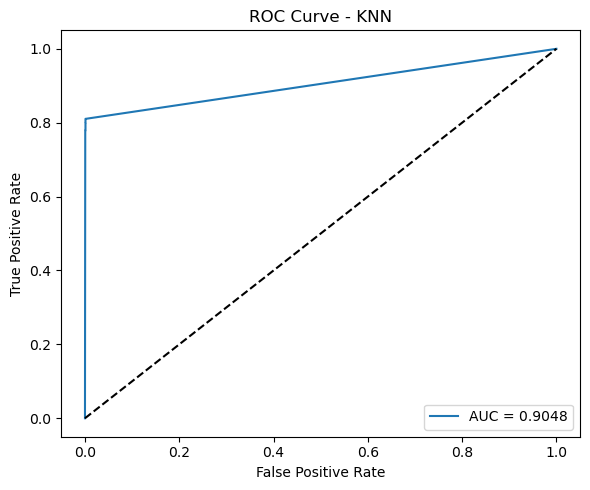

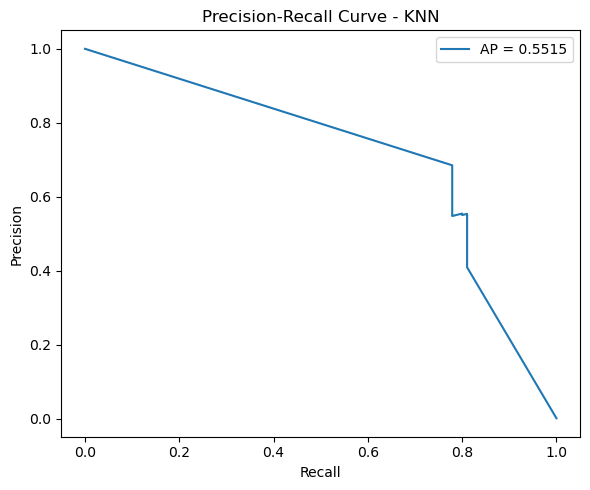

In [21]:
# === Plot Precision, Recall, F1 vs Threshold ===
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.plot(thresholds, f1_scores, label='F1-score', linewidth=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best F1 Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, F1 vs Threshold (KNN)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig("knn_threshold_tuning.png", dpi=300)
plt.show()

# === Evaluate KNN at Optimal F1 Threshold ===
# Final predictions with F1-optimal threshold
y_pred_opt = (y_proba >= best_threshold).astype(int)
cm_opt = confusion_matrix(y_test, y_pred_opt)
print("\nConfusion Matrix at Best F1 Threshold:")
print(cm_opt)
print(pd.DataFrame(classification_report(y_test, y_pred_opt, output_dict=True)).transpose())

# === Confusion Matrix Heatmap (Optimized Threshold) ===
plt.figure(figsize=(6, 5))
sns.heatmap(cm_opt, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'],
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title(f'Confusion Matrix - KNN (Threshold = {best_threshold:.2f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.savefig("knn_confusion_matrix_optimized.png", dpi=300)
plt.show()

# === ROC Curve ===
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"\nROC AUC Score: {roc_auc:.4f}")
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("knn_roc_curve.png", dpi=300)
plt.show()

# === Precision-Recall Curve ===
precision, recall, _ = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'AP = {avg_precision:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - KNN')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("knn_precision_recall_curve.png", dpi=300)
plt.show()